In [1]:
import numpy as np
import pandas as pd
import os
import time
import re
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
folder = 'input'

In [3]:
# turn categorical data to one hot encoded format
def one_hot_encode(df, create_category_if_nan = True):
    columns = df.columns.tolist()
    categorical = []
    for col in df:
        if df[col].dtype == 'object':
            categorical.append(col)
    df = pd.get_dummies(df, columns=categorical, dummy_na=create_category_if_nan)
    one_hot_categorical = []
    for col in df:
        if col not in columns:
            one_hot_categorical.append(col)
    return df, one_hot_categorical

# remove punctuation in column names
def clean_column_names(df):
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    return df

# drop columns which are completely zeros
def clean_empty_columns(df):
    drop_col = []
    for col in df:
        total = df[col].sum()
        if total == 0:
            drop_col.append(col)
    df = df.drop(labels=drop_col,axis=1)
    return df

# fill in the nan with median of the column for numerical data
def fill_na_median(df):
    for col in df.columns[df.isna().any()].tolist():
        np_array = df[col].to_numpy()
        df[col] = df[col].fillna(np.median(np_array[~np.isnan(np_array)]))
    return df

# check whether lightgbm with gpu is installed
def check_gpu_support():
    data = np.random.rand(50, 2)
    label = np.random.randint(2, size=50)
    train_data = lgb.Dataset(data, label=label)
    params = {'num_iterations': 1, 'device': 'gpu', 'verbose': -1}
    try:
        gbm = lgb.train(params, train_set=train_data)
        return 'gpu'
    except Exception as e:
        return 'cpu'

In [4]:
train_df = pd.read_csv(os.path.join(folder,'application_train.csv'))
test_df = pd.read_csv(os.path.join(folder,'application_test.csv'))
# print("train_df",len(train_df),"test_df",len(test_df))
train_df = train_df.append(test_df)
train_df.reset_index(inplace=True,drop=True)

# remove XNA gender because only 4 people is XNA and test set does not have XNA
train_df = train_df[train_df['CODE_GENDER'] != 'XNA']
# remove extreme outliers in training data
train_df = train_df[train_df['AMT_INCOME_TOTAL'] < 20000000]
# these values does not make sense from the data description
train_df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
train_df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

train_df, train_cat = one_hot_encode(train_df, True)

# some feature engineering
# a client that is more recently employed may indicate that his income source is not stable
train_df['DAYS_EMPLOYED_PERCENT'] = train_df['DAYS_EMPLOYED'] / train_df['DAYS_BIRTH']
# a client that has a low income to credit ratio may indicate that his main income is insufficient to deal with emergency situations
train_df['INCOME_CREDIT_PERCENT'] = train_df['AMT_INCOME_TOTAL'] / train_df['AMT_CREDIT']
# a client with low income per person may indicate a financial hardship
train_df['INCOME_PER_PERSON'] = train_df['AMT_INCOME_TOTAL'] / train_df['CNT_FAM_MEMBERS']
# a client with high annuity to income ratio maybe more likely to default
train_df['ANNUITY_INCOME_PERCENT'] = train_df['AMT_ANNUITY'] / train_df['AMT_INCOME_TOTAL']
# a client with high payment rate maybe less likely to default
train_df['PAYMENT_RATE'] = train_df['AMT_ANNUITY'] / train_df['AMT_CREDIT']
# a client with low goods price to credit ratio maybe more likely to default
train_df['GOOD_PRICE_CREDIT_RATIO'] = train_df['AMT_GOODS_PRICE'] / train_df['AMT_CREDIT']

In [5]:
bureau = pd.read_csv(os.path.join(folder,'bureau.csv'))
bureau, bureau_categorical = one_hot_encode(bureau,True)

bureau_balance = pd.read_csv(os.path.join(folder,'bureau_balance.csv'))
bureau_balance, bureau_balance_categorical = one_hot_encode(bureau_balance,True)

bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'sum', 'size']}
for col in bureau_balance_categorical:
    bb_aggregations[col] = ['mean']
bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)

In [6]:
bureau = pd.read_csv(os.path.join(folder,'bureau.csv'))
bureau, bureau_categorical = one_hot_encode(bureau,True)

bureau_balance = pd.read_csv(os.path.join(folder,'bureau_balance.csv'))
bureau_balance, bureau_balance_categorical = one_hot_encode(bureau_balance,True)

bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'sum', 'size']}
for col in bureau_balance_categorical:
    bb_aggregations[col] = ['mean']
bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
# Flatten column names
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)

# based on model importance
bureau_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}

# Bureau and bureau_balance features
for cat in bureau_categorical:
    bureau_aggregations[cat] = ['mean']
for cat in bureau_balance_categorical:
    bureau_aggregations[cat + "_MEAN"] = ['mean']
bureau_aggs = bureau.groupby('SK_ID_CURR').agg(bureau_aggregations)
# Flatten column names
bureau_aggs.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_aggs.columns.tolist()])
bureau = bureau_aggs

train_df = train_df.join(bureau, how='left', on='SK_ID_CURR')

In [7]:
cc = pd.read_csv(os.path.join(folder,'credit_card_balance.csv'))
cc, cat_cols = one_hot_encode(cc,True)

cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)

# some feature engineering
# a client with high amount used from limit maybe more likely to default
cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
# a client with low current payment to min payment ratio may indicate financial hardship
cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
# whether a client has late payment
cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
# a client with high drawing to limit ratio may indicate financial hardship
cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']

# based on model importance
credit_aggregations = {
    'MONTHS_BALANCE':['var','min','mean'],
    'AMT_BALANCE':['min','max','mean','sum','var'],
    'AMT_CREDIT_LIMIT_ACTUAL':['min','max','mean','sum','var'],
    'AMT_DRAWINGS_ATM_CURRENT':['max','var','sum','mean'],
    'AMT_DRAWINGS_CURRENT':['max','var','sum','mean'],
    'AMT_DRAWINGS_OTHER_CURRENT':['mean','var','max'],
    'AMT_DRAWINGS_POS_CURRENT':['max','var','sum','mean'],
    'AMT_INST_MIN_REGULARITY':['min','max','mean','sum','var'],
    'AMT_PAYMENT_CURRENT':['min','max','mean','sum','var'],
    'AMT_PAYMENT_TOTAL_CURRENT':['min','max','mean','sum','var'],
    'AMT_RECEIVABLE_PRINCIPAL':['min','max','mean','sum','var'],
    'AMT_RECIVABLE':['min','max','mean','sum','var'],
    'AMT_TOTAL_RECEIVABLE':['min'],
    'CNT_DRAWINGS_ATM_CURRENT':['max','mean','sum','var'],
    'CNT_DRAWINGS_CURRENT':['max','mean','sum','var'],
    'CNT_DRAWINGS_OTHER_CURRENT':['mean','var'],
    'CNT_DRAWINGS_POS_CURRENT':['max','mean','sum','var'],
    'CNT_INSTALMENT_MATURE_CUM':['max','mean','sum','var'],
    'SK_DPD':['min','max','mean','sum','var'],
    'SK_DPD_DEF':['max','mean','sum','var'],
    'LIMIT_USE': ['max', 'mean'],
    'PAYMENT_DIV_MIN': ['min', 'mean'],
    'LATE_PAYMENT': ['max', 'sum'],
    'DRAWING_LIMIT_RATIO':['min','max','mean','sum','var'],
}
cc_aggs = cc.groupby('SK_ID_CURR').agg(credit_aggregations)
cc_aggs.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_aggs.columns.tolist()])
# Count credit card lines
cc_aggs['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
cc = cc_aggs

train_df = train_df.join(cc, how='left', on='SK_ID_CURR')

In [8]:
ins = pd.read_csv('./input/installments_payments.csv')
ins, cat_cols = one_hot_encode(ins,True)

# some feature engineering
# a client with high payment ratio maybe less likely to default
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due
# a client that have past due maybe more likely to default
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x <= 0 else x)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x <= 0 else x)

# based on model importance
ins_aggregations = {
    'SK_ID_PREV': ['size', 'nunique'],
    'DPD': ['max', 'mean', 'sum', 'var'],
    'DBD': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['min','max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean', 'sum']
}
for cat in cat_cols:
    ins_aggregations[cat] = ['mean']
    
ins_aggs = ins.groupby('SK_ID_CURR').agg(ins_aggregations)
ins_aggs.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_aggs.columns.tolist()])
ins = ins_aggs

train_df = train_df.join(ins, how='left', on='SK_ID_CURR')

In [9]:
pos = pd.read_csv('./input/POS_CASH_balance.csv')
pos, cat_cols = one_hot_encode(pos,True)

# based on model importance
pos_aggregations = {
    'SK_ID_PREV': ['nunique'],
    'MONTHS_BALANCE': ['min','max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    pos_aggregations[cat] = ['mean']

pos_aggs = pos.groupby('SK_ID_CURR').agg(pos_aggregations)
pos_aggs.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_aggs.columns.tolist()])
pos = pos_aggs

train_df = train_df.join(pos, how='left', on='SK_ID_CURR')

In [10]:
prev = pd.read_csv('./input/previous_application.csv')
prev, cat_cols = one_hot_encode(prev,True)

# these values does not make sense from the data description
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

# some feature engineering
# amount requested and amount received may indicate the trust of the lender towards the client
prev['APP_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

# based on model importance
prev_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_DIFF':['min', 'max', 'mean', 'var'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum', 'max'],
    'DAYS_FIRST_DRAWING': ['max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['max', 'mean'],
}
for cat in cat_cols:
    prev_aggregations[cat] = ['mean']

prev_aggs = prev.groupby('SK_ID_CURR').agg(prev_aggregations)
prev_aggs.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_aggs.columns.tolist()])
prev = prev_aggs

train_df = train_df.join(prev, how='left', on='SK_ID_CURR')

In [11]:
# final cleaning
train_df = clean_column_names(train_df)
train_df = clean_empty_columns(train_df)
test_df = train_df[train_df['TARGET'].isnull()]
train_df = train_df[train_df['TARGET'].notnull()]
# print("train_df",len(train_df),"test_df",len(test_df))
# train_df = fill_na_median(train_df)

In [12]:
# prepare training and testing data
train_df_temp = train_df.copy()
y = train_df_temp['TARGET']
train_feats = [feat for feat in train_df_temp if feat not in ['SK_ID_CURR','TARGET']]
train_df_temp = train_df_temp[train_feats]
x = train_df_temp
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1)

# prepare submission data
test_df_temp = test_df.copy()
test_pred = test_df[['SK_ID_CURR','TARGET']]
test_pred.reset_index(drop=True,inplace=True)
test_feats = [feat for feat in train_df_temp if feat not in ['SK_ID_CURR','TARGET']]
test_df_temp = test_df_temp[test_feats]

In [13]:
# settings
do_cv = False
fast_approximate = False

In [14]:
# lgbm settings
device = check_gpu_support()
lr = 0.005
n_leaves = 70
n_fold = 10
if fast_approximate:
    lr = 0.01
    n_leaves = 50
    n_fold = 5

In [15]:
# cross validation
if do_cv:
    params = {
        'boosting_type': 'gbdt', 
        'objective': 'binary', 
        'learning_rate': lr, 
        'num_leaves': n_leaves, 
        'max_depth': 10,
        'min_data_in_leaf': 15,
        'min_child_weight': 0.0001,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'feature_fraction':0.78,
        'device_type': device,
        }

    t0 = time.time()
    data_train = lgb.Dataset(x, y, silent=True)
    cv_results = lgb.cv(params, data_train, num_boost_round=10000, nfold=n_fold, stratified=False, shuffle=True, metrics='auc',
                        early_stopping_rounds=50, verbose_eval=100, show_stdv=True, return_cvbooster=True)
    
    print("done in {:.0f}s".format(time.time() - t0))

    print('best n_estimators:', len(cv_results['auc-mean']))
    print('best cv score:', cv_results['auc-mean'][-1])

    cvbooster = cv_results['cvbooster']
    best_iter = cvbooster.best_iteration
    num_boosters = n_fold
    preds = np.zeros(test_df.shape[0]) 
    for i in range(num_boosters):
        preds += cvbooster.boosters[i].predict(test_df_temp,num_iteration=best_iter)/num_boosters
    test_pred['TARGET'] = preds
    test_pred.to_csv('submission_test_cv.csv',index=False)

In [16]:
if not do_cv:
    t0 = time.time()
    # use the hyparameters tune by above
    model = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', learning_rate=lr, num_leaves=n_leaves, max_depth=10, n_estimators=5000,
                               min_data_in_leaf=15, min_child_weight=0.0001, bagging_fraction=0.8,bagging_freq=5,feature_fraction=0.78,device_type=device, 
                               stratified=False, shuffle=True, metrics='auc',
                               early_stopping_rounds=50, verbose_eval=100, show_stdv=True)
    model.fit(X=X_train, y=y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=50, verbose=200)
    print("done in {:.0f}s".format(time.time() - t0))

    preds = model.predict_proba(test_df_temp,num_iteration=model.best_iteration_)[:,1]
    test_pred['TARGET'] = preds
    test_pred.to_csv('submission_test_single.csv',index=False)

[200]	training's auc: 0.788479	valid_1's auc: 0.761614
[400]	training's auc: 0.814328	valid_1's auc: 0.776784
[600]	training's auc: 0.832708	valid_1's auc: 0.782661
[800]	training's auc: 0.848199	valid_1's auc: 0.786236
[1000]	training's auc: 0.861871	valid_1's auc: 0.787994
[1200]	training's auc: 0.874194	valid_1's auc: 0.78905
done in 120s


In [17]:
# get feature importance from model
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,x.columns)), columns=['Value','Feature'])

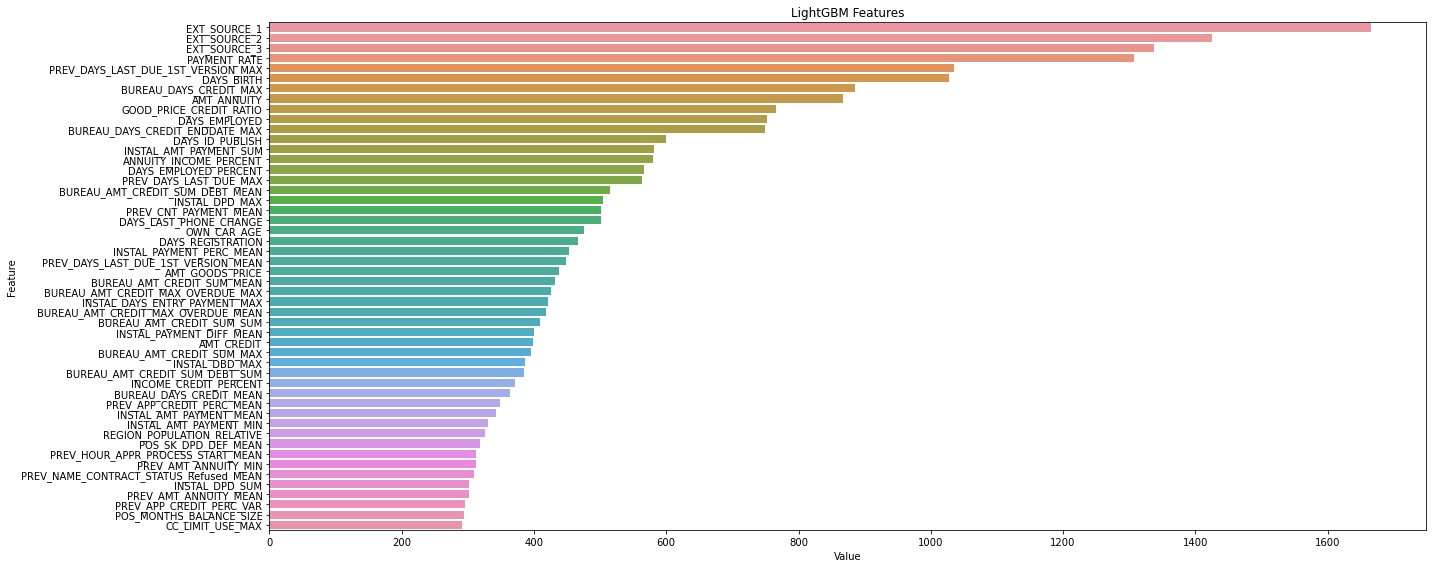

In [18]:
# visualize importance
plt.figure(figsize=(20, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50,:])
plt.title('LightGBM Features')
plt.tight_layout()
# plt.savefig('lgbm_importance_own_all_features_.png')
plt.show()

In [19]:
# feature_imp.to_csv('feature_importance_.csv')